# Pencil beam sinogram & reconstruction

## Sinogram from phantom

Let us first compute the sinogram from the phantom. The sinogram is what we would obtain from a tomographic scan and that then should be projected back.

<IPython.core.display.Javascript object>


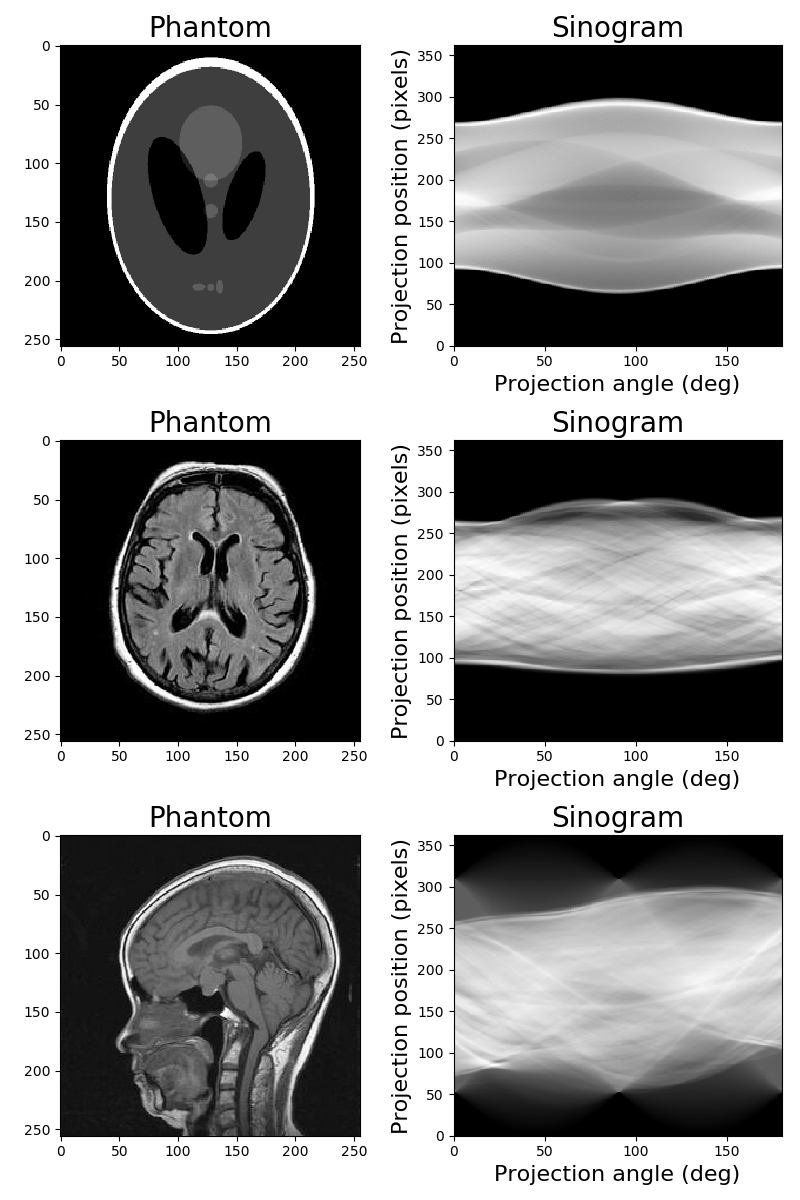

In [24]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../design/')
from image import Image
from phantom import Phantom
from sinogram import Sinogram

fig, axes = plt.subplots(3, 2, figsize=(8, 12))
axes = axes.flatten()

size = 256
max_theta = 180
phantoms = ['shepplogan.gif', 'brain2.jpg', 'brain3.jpg']
thetas = np.arange(max_theta, step=1)

for i in range(len(phantoms)):
    phantom = Phantom(phantoms[i], size=-1, blur=-1, noise=-1)
    sinogram = Sinogram(phantom)
    sinogram.compute(thetas)
    Image.plot(phantom.img,
               axes[2 * i],
               title='Phantom')
    Image.plot(sinogram.sng,
               axes[2 * i + 1],
               title='Sinogram', 
               x_label='Projection angle (deg)', 
               y_label='Projection position (pixels)', 
               extent=(0, 180, 0, sinogram.sng.shape[0]), 
               aspect='auto')

fig.tight_layout()

## Backprojection

We can try a first backprojection from the last sinogram, with no filtering to see what we obtain and the error associated.

FBP rms reconstruction error: 2.66e+04


<IPython.core.display.Javascript object>


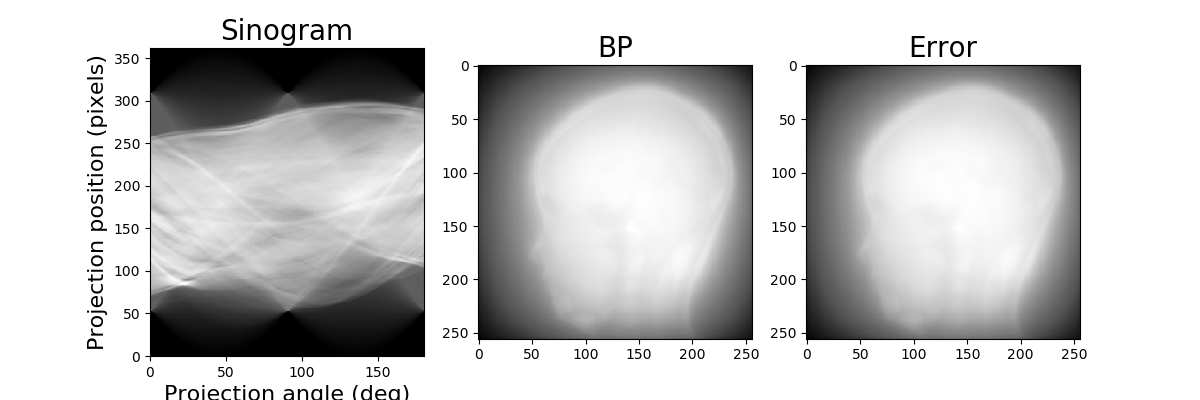

In [25]:
from fbp import FBP

size = 256
max_theta = 180
thetas = np.arange(max_theta, step=1)
phantom = Phantom('brain3.jpg', size=-1, blur=-1, noise=-1)
sinogram = Sinogram(phantom)
sinogram.compute(thetas)

fbp = FBP.compute(sinogram, thetas, filtering=False)

error = fbp - phantom.img
print('FBP rms reconstruction error: %.3g' % np.sqrt(np.mean(error**2)))

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

Image.plot(sinogram.sng,
           ax1,
           title='Sinogram', 
           x_label='Projection angle (deg)', 
           y_label='Projection position (pixels)', 
           extent=(0, 180, 0, sinogram.sng.shape[0]), 
           aspect='auto')
Image.plot(fbp,
           ax2,
           title='BP')
Image.plot(error,
           ax3,
           title='Error')

## Filtered backprojection

We see that this filtering must be necessary in order to obtain a clean image. Let us add this filtering.

FBP rms reconstruction error: 23.5


<IPython.core.display.Javascript object>


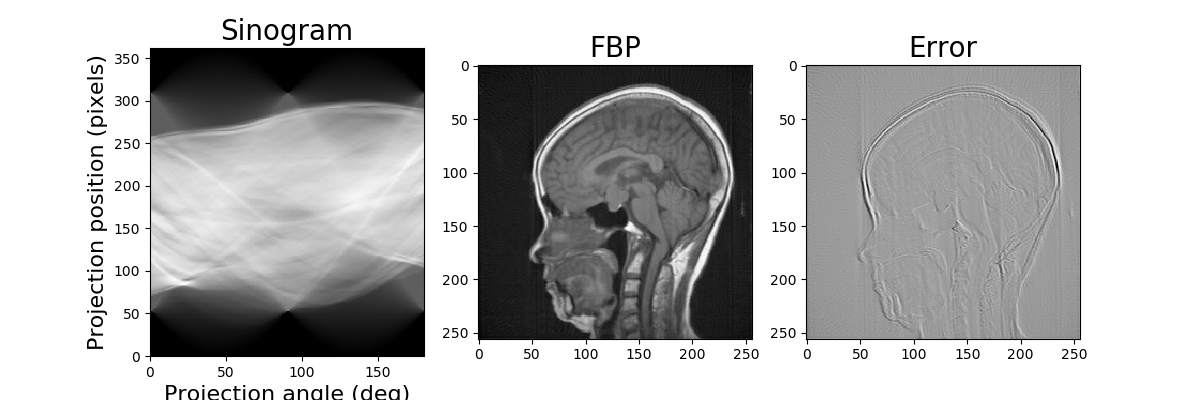

In [26]:
from fbp import FBP

fbp = FBP.compute(sinogram, thetas)

error = fbp - phantom.img
rms = np.sqrt(np.mean(error**2))
print('FBP rms reconstruction error: %.3g' % rms)

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

Image.plot(sinogram.sng,
           ax1,
           title='Sinogram', 
           x_label='Projection angle (deg)', 
           y_label='Projection position (pixels)', 
           extent=(0, 180, 0, sinogram.sng.shape[0]), 
           aspect='auto')
Image.plot(fbp,
           ax2,
           title='FBP')
Image.plot(error,
           ax3,
           title='Error')

## Animating reconstruction

In the process of reconstruction, each projection angle, corresponding to a slice of the sinogram, is backprojected. The final backprojection results from the sum of each of those individual slice backprojections, computed one after the other. We can then animate how the image is obtained.

<IPython.core.display.Javascript object>


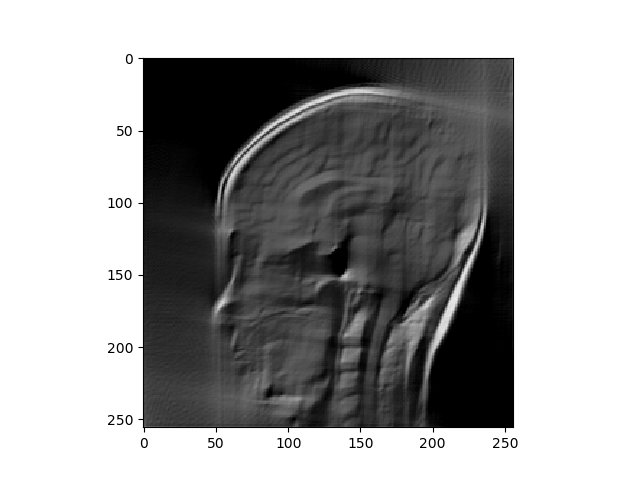

In [27]:
import matplotlib.animation as animation

thetas = np.arange(180)
fbp = FBP.compute(sinogram, thetas, detail=True)

fig = plt.figure()
im = plt.imshow(fbp[len(thetas) - 1], cmap=plt.cm.Greys_r)

def make_frame(t):
    im.set_array(fbp[t % 250])
    return im,

animation.FuncAnimation(fig, make_frame, interval=20)

## Error dependency on projection angles

The reconstruction process is highly dependent on the projection angles. We can first remark that if our projections do not cover all angles, our reconstruction will be incomplete (as in the previous animation, until we reach the last angle).

<IPython.core.display.Javascript object>


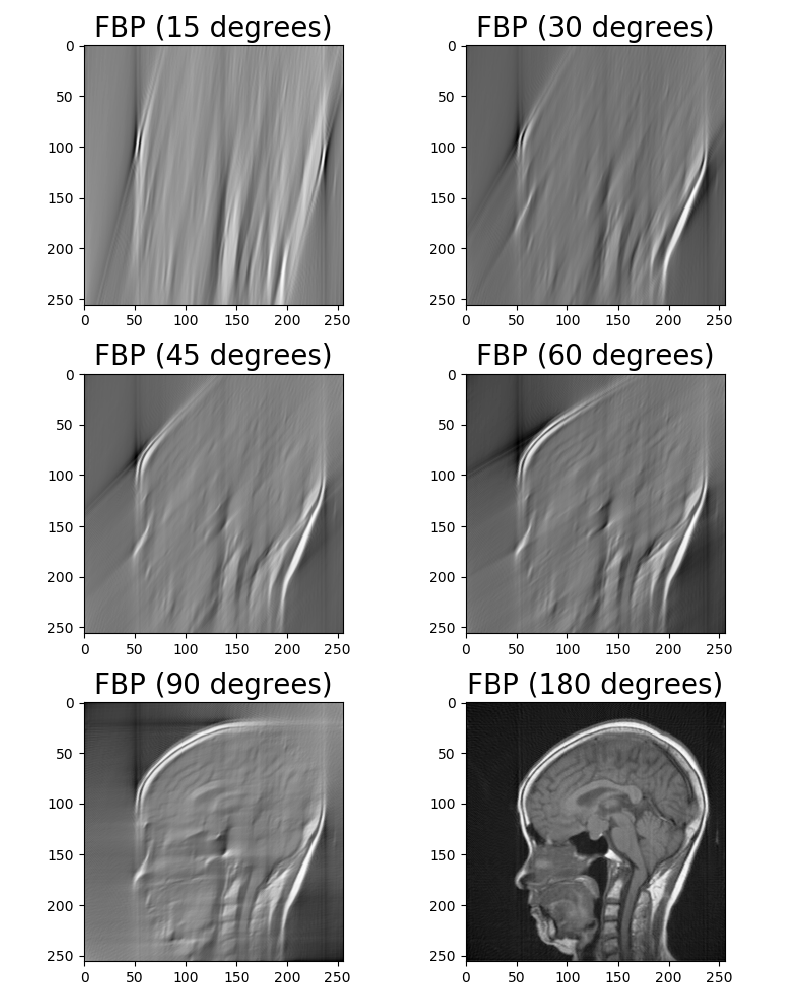

In [28]:
size = 256
phantom = Phantom('brain3.jpg', size=-1, blur=-1, noise=-1)
sinogram = Sinogram(phantom)

max_thetas = [15, 30, 45, 60, 90, 180]
axes = np.zeros(len(max_thetas))
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes = axes.flatten()

for i in range(len(max_thetas)):
    thetas = np.arange(max_thetas[i], step=1)
    sinogram.compute(thetas)
    fbp = FBP.compute(sinogram, thetas)
    Image.plot(fbp,
               axes[i],
               title='FBP (%s degrees)' % max_thetas[i])

fig.tight_layout()

The more projection angles you have, the more precise and close to the reality the FBP image will be.

<IPython.core.display.Javascript object>


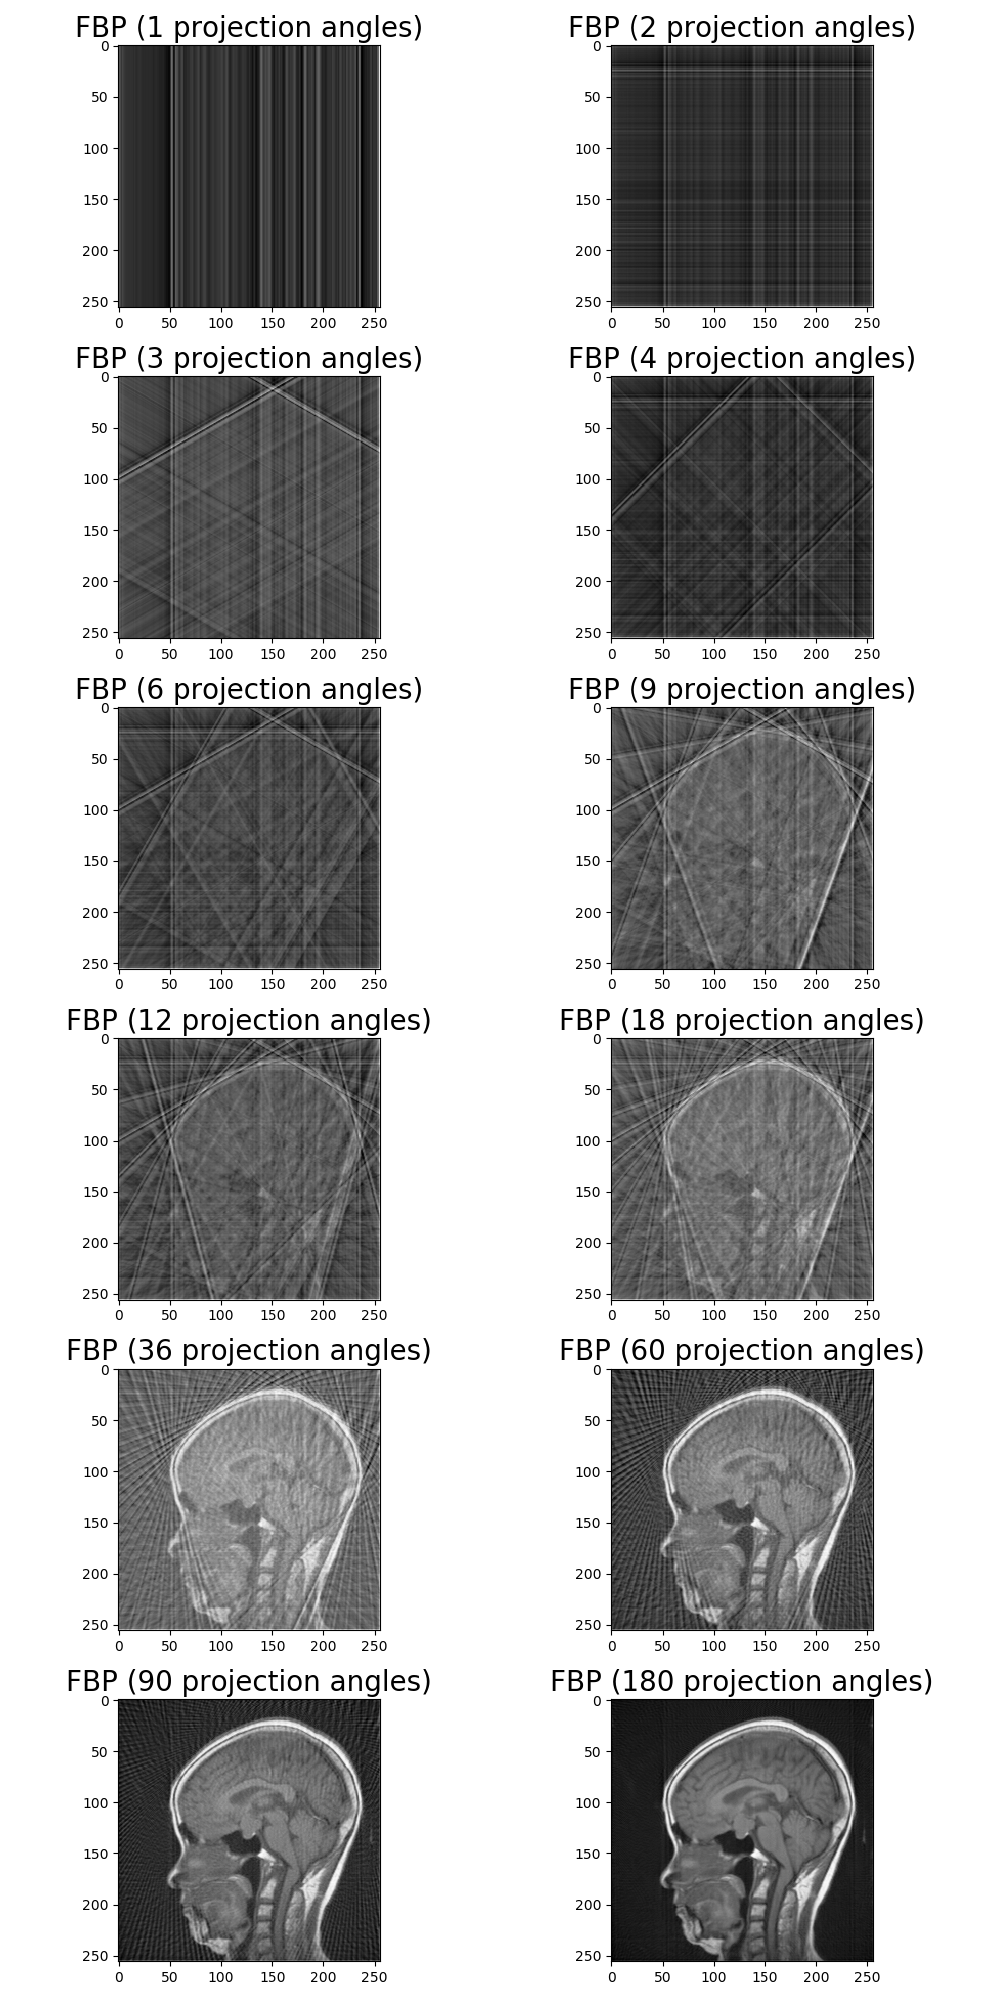

In [30]:
size = 256
phantom = Phantom('brain3.jpg', size=-1, blur=-1, noise=-1)
sinogram = Sinogram(phantom)

steps = [180, 90, 60, 45, 30, 20, 15, 10, 5, 3, 2, 1]
axes = np.zeros(len(steps))
fig, axes = plt.subplots(6, 2, figsize=(10, 20))
axes = axes.flatten()

for i in range(len(steps)):
    thetas = np.arange(180, step=steps[i])
    sinogram.compute(thetas)
    fbp = FBP.compute(sinogram, thetas)
    Image.plot(fbp,
               axes[i],
               title='FBP (%s projection angles)' % (180 // steps[i]))

fig.tight_layout()

To evaluate this precision, we can plot the error RMS value according to the number of projection angles.

<IPython.core.display.Javascript object>


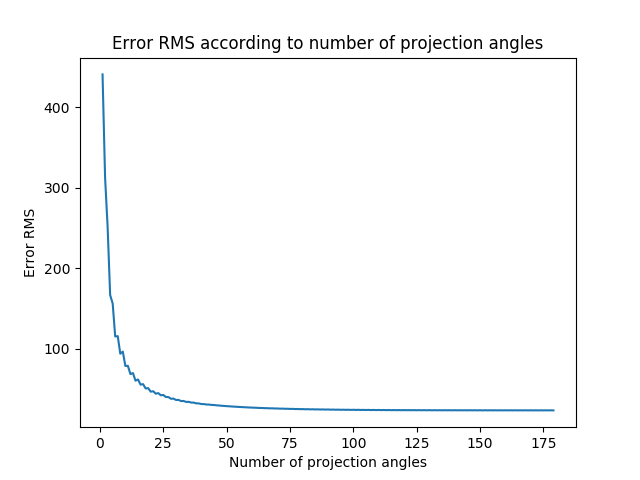

In [31]:
size = 256
phantom = Phantom('brain3.jpg', size=-1, blur=-1, noise=-1)
sinogram = Sinogram(phantom)

num_projs = np.arange(1, 180)
rms = []
for t in num_projs:
    thetas = np.linspace(0, 180, t)
    sinogram.compute(thetas)
    fbp = FBP.compute(sinogram, thetas)
    error = fbp - phantom.img
    rms.append(np.sqrt(np.mean(error**2)))

fig = plt.figure()
plt.plot(num_projs, rms)
plt.title('Error RMS according to number of projection angles')
plt.xlabel('Number of projection angles')
plt.ylabel('Error RMS')
plt.show()

It seems to tend to a certain value. It is logical, because our filtering part in the FBP algorithm is done using a ramp filter. This ramp filter is equal to zero for the zero spatial frequency, deleting the ground spatial signal of the image. There is then a systematic error on the computed reconstruction.

## Backprojection Filtered

It can also be interesting to see what happens if we filter the result after backprojecting and not before (filtering the reconstruction image and not the sinogram slices). Some algorithms are built on this model, mostly for reconstruction from cone beam data.

FBP rms reconstruction error: 73


<IPython.core.display.Javascript object>


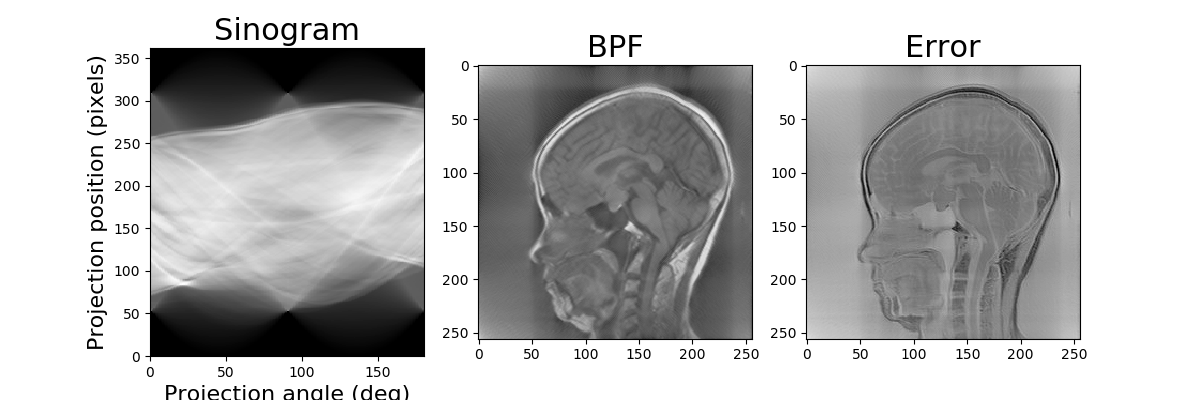

In [3]:
from fbp import FBP

fbp = FBP.compute_bpf(sinogram, thetas)

error = fbp - phantom.img
print('FBP rms reconstruction error: %.3g' % np.sqrt(np.mean(error**2)))

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

Image.plot(sinogram.sng,
           ax1,
           title='Sinogram', 
           x_label='Projection angle (deg)', 
           y_label='Projection position (pixels)', 
           extent=(0, 180, 0, sinogram.sng.shape[0]), 
           aspect='auto')
Image.plot(fbp,
           ax2,
           title='BPF')
Image.plot(error,
           ax3,
           title='Error')

We observe that the result is not really satisfying for a parallel beam.